In [4]:
import numpy as np
import pandas as pd
import sklearn as sk
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [5]:
df = pd.read_csv("dataset.csv")
df.head()
df.shape
df.info()
df.describe()
df.isnull().sum() #check if there are missing values in data

x = df["Text"]
y = df["language"]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22000 entries, 0 to 21999
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Text      22000 non-null  object
 1   language  22000 non-null  object
dtypes: object(2)
memory usage: 343.9+ KB


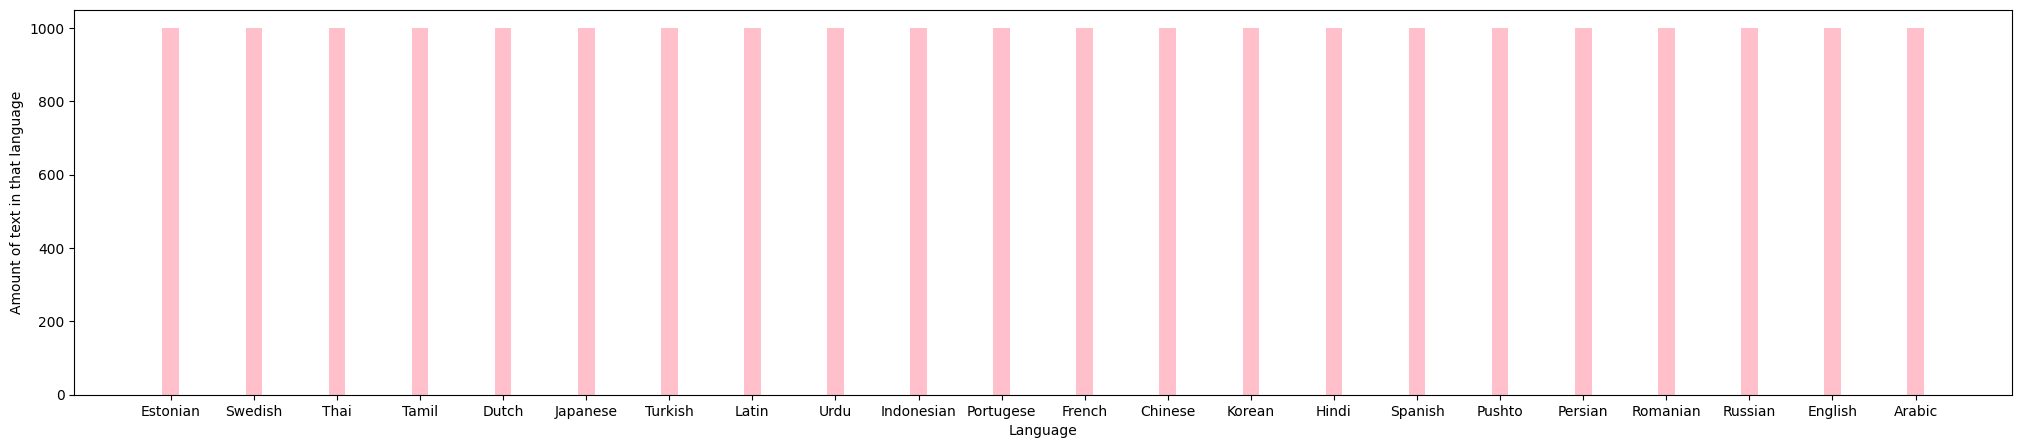

In [6]:
fig = plt.figure(figsize=(25, 5))
plt.bar(df["language"].unique(), list(df["language"].value_counts()), color='pink', width=0.2)
plt.xlabel("Language")
plt.ylabel("Amount of text in that language")
plt.show()
#we check how many texts in which language we have so we can see if we have a balanced data set.
#each language has 1000 texts.

In [7]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(x)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, test_size=0.2)

(22000, 277720)


In [8]:
# helper function for predicting the given text, we first need to vectorize the text then we can use it for prediction
def predict(clf, text, vectorizer):
    # form an array that matches the features accounted for in the vectorizer
    array = np.zeros((1, len(vectorizer.get_feature_names_out())))
    counter = 0
    # fill in each feature manually
    for name in vectorizer.get_feature_names_out():
        if text.lower().count(name):
            array[0][counter] = text.lower().count(name)
        counter+= 1
    # return the prediction of the classifier
    return clf.predict(array)

In [9]:
#MultinomialNB classifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV

#hyperparameter tuning
clf = MultinomialNB()
param={'alpha': [0.00001, 0.0001, 0.001, 0.1, 1, 10, 100,1000]}
grid = GridSearchCV(clf, param, scoring='accuracy', cv=10, return_train_score=True)
grid_search = grid.fit(X_train, y_train)
print(grid_search.best_params_)

{'alpha': 1e-05}


In [10]:
#fitting the model with the best parameter
clf = MultinomialNB(alpha = 0.0001)
clf.fit(X_train, y_train)

#predict any text, just assign your input to the text variable
text = "Het regent pijpenstelen."
print(predict(clf, text, vectorizer)) # you can predict any text just by changing the text variable

['Dutch']


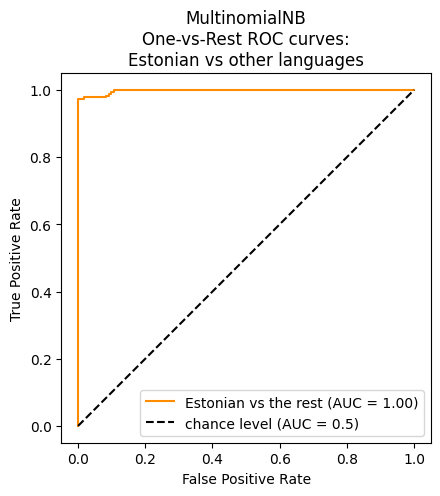

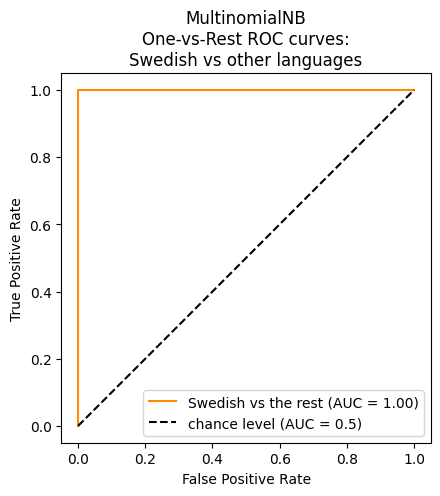

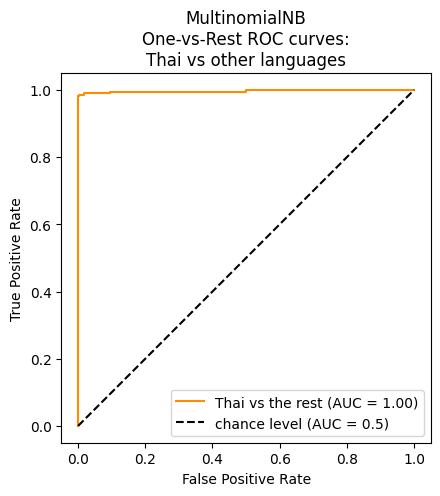

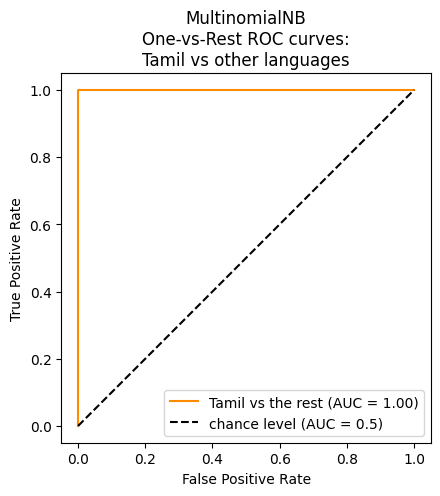

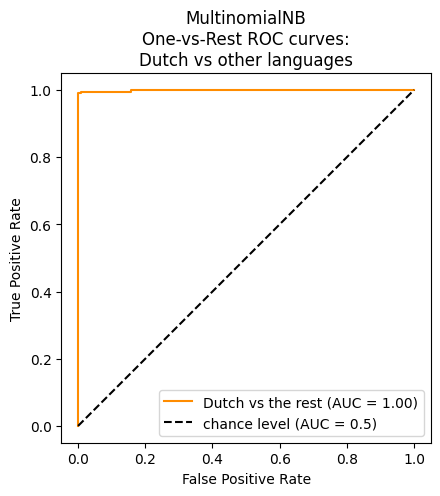

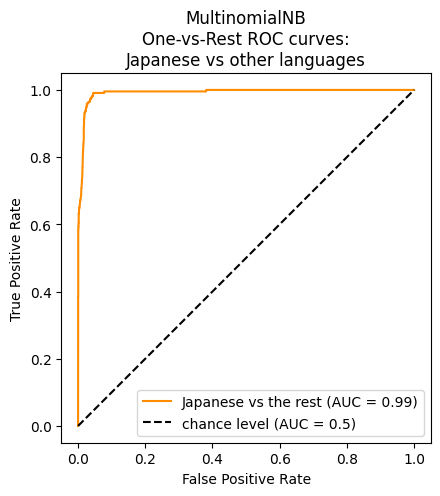

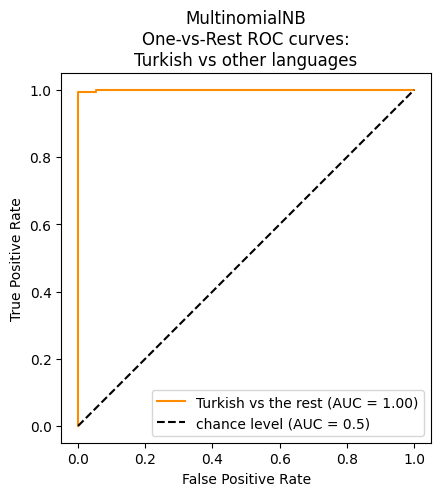

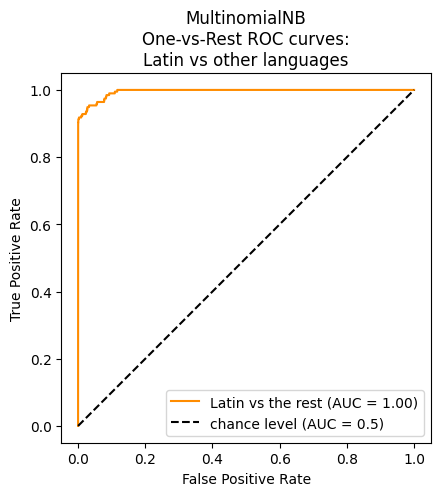

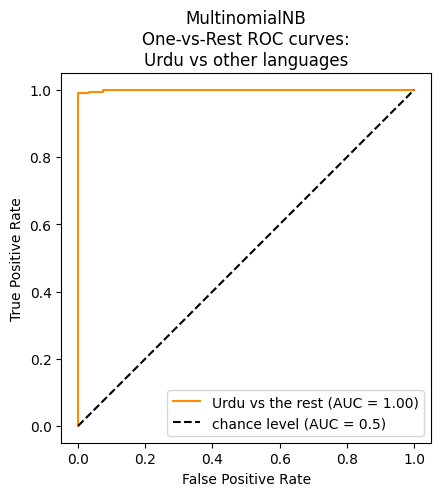

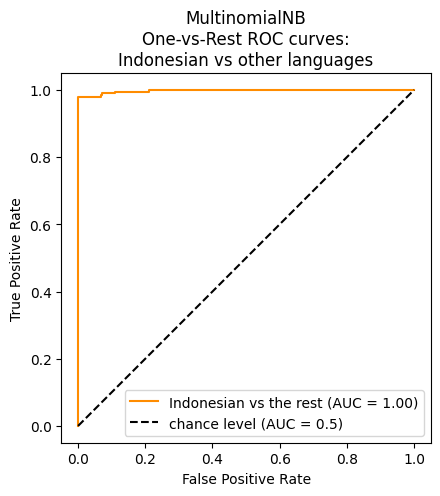

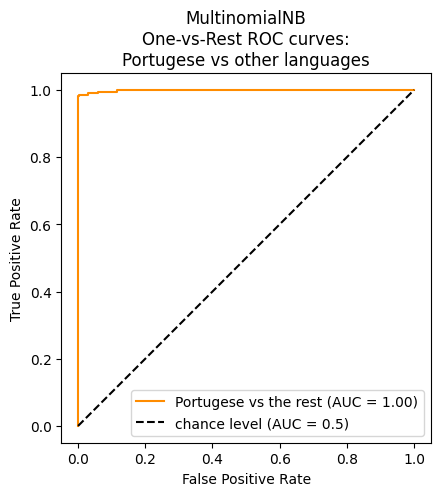

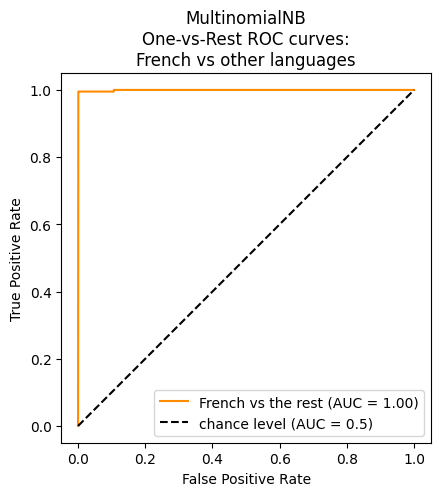

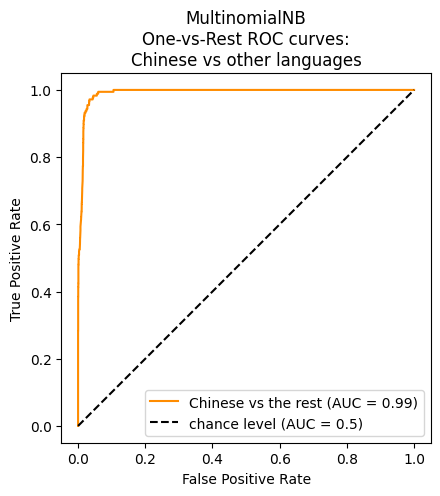

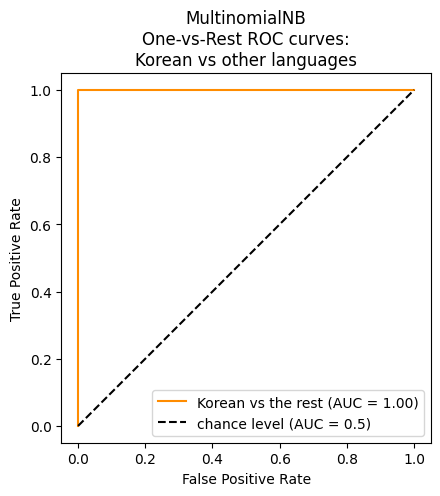

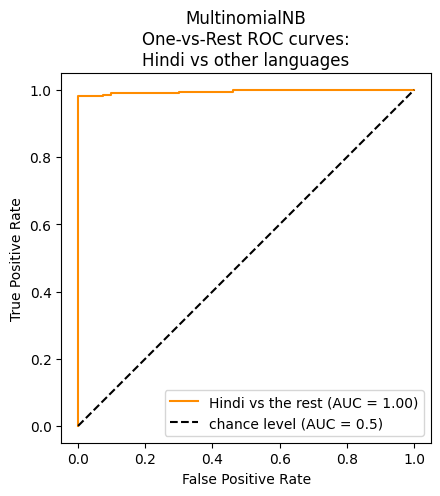

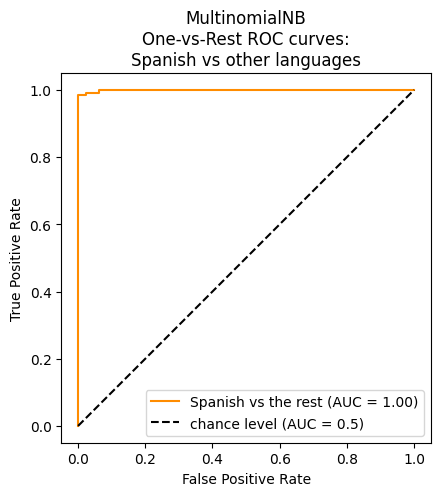

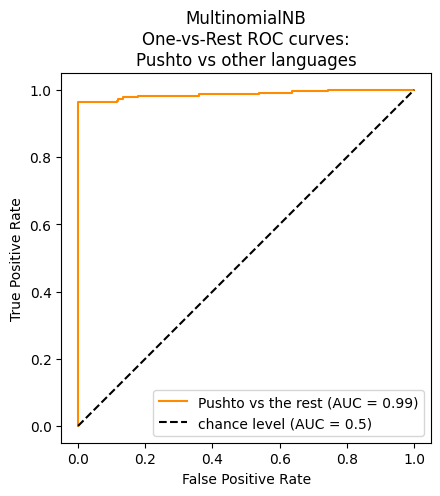

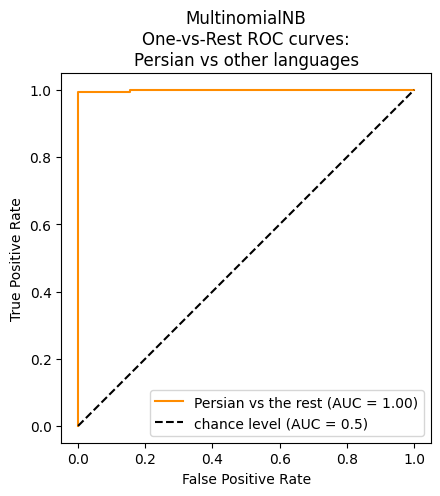

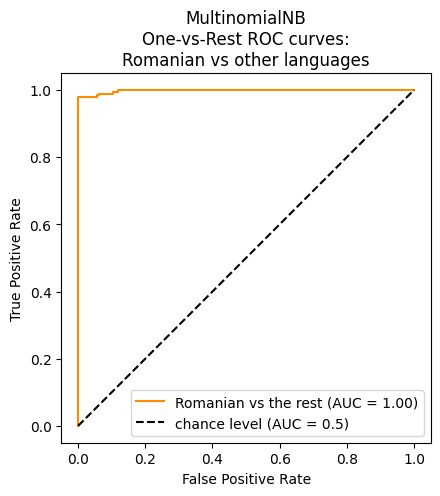

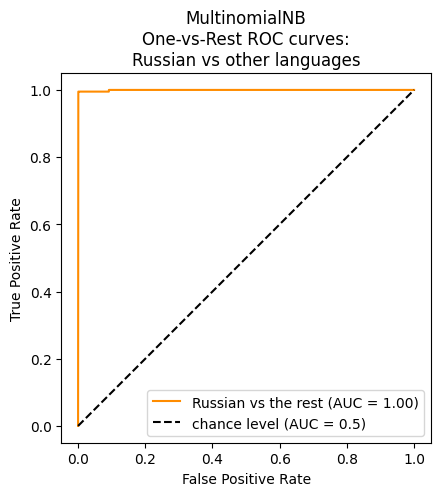

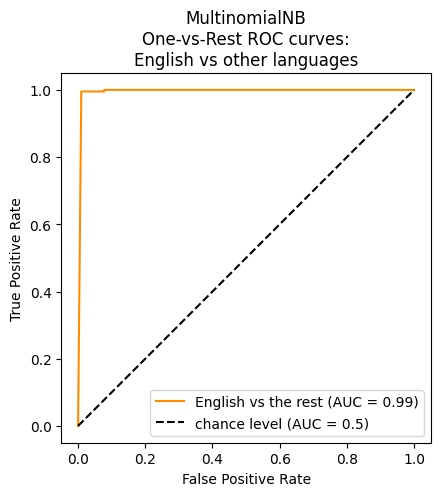

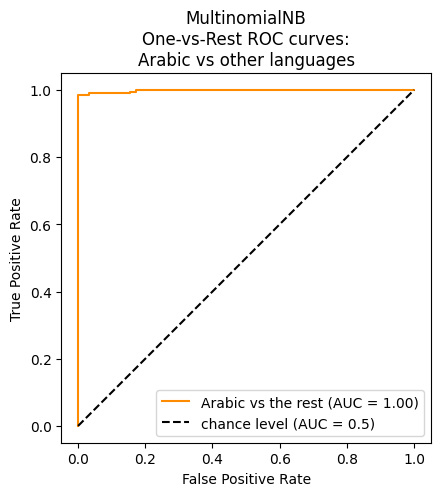

In [16]:
#OvR ROC Curve for MultinomialNB

from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import RocCurveDisplay

label_binarizer = LabelBinarizer().fit(y_train)
y_onehot_test = label_binarizer.transform(y_test)

y_score = clf.fit(X_train, y_train).predict_proba(X_test)

for lang in y.unique():
    class_of_interest = lang
    class_id = np.flatnonzero(label_binarizer.classes_ == class_of_interest)[0]
    RocCurveDisplay.from_predictions(
        y_onehot_test[:, class_id],
        y_score[:, class_id],
        name=f"{class_of_interest} vs the rest",
        color="darkorange",)

    plt.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
    plt.axis("square")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("MultinomialNB\nOne-vs-Rest ROC curves:\n" + class_of_interest + " vs other languages")
    plt.legend()
    plt.show()

In [12]:
#KNN classifier
from sklearn.neighbors import KNeighborsClassifier

#hyperparameter tuning, find the best k value with GridSearch
knn = KNeighborsClassifier()
k_range = list(range(1, 21))
param_grid = dict(n_neighbors=k_range, metric=["cityblock", "cosine", "euclidean", "manhattan"])

grid = GridSearchCV(knn, param_grid, cv=10, scoring='accuracy', return_train_score=False,verbose=1)
grid_search = grid.fit(X_train, y_train)
print(grid_search.best_params_)

Fitting 10 folds for each of 80 candidates, totalling 800 fits
{'metric': 'cosine', 'n_neighbors': 1}


In [13]:
knn = KNeighborsClassifier(n_neighbors=grid_search.best_params_["n_neighbors"], metric=grid_search.best_params_["metric"])
knn.fit(X_train, y_train)
print(knn.score(X_test, y_test))

0.9334090909090909


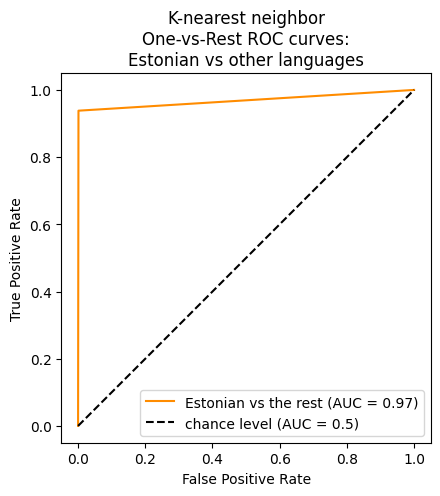

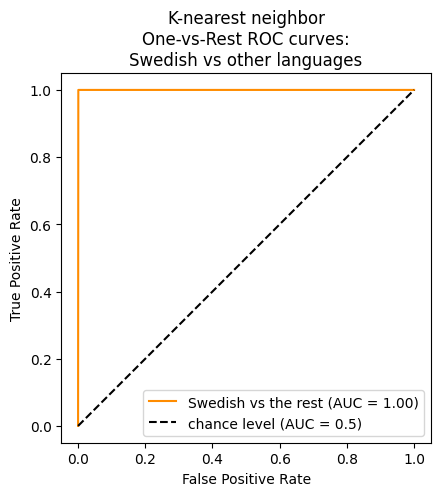

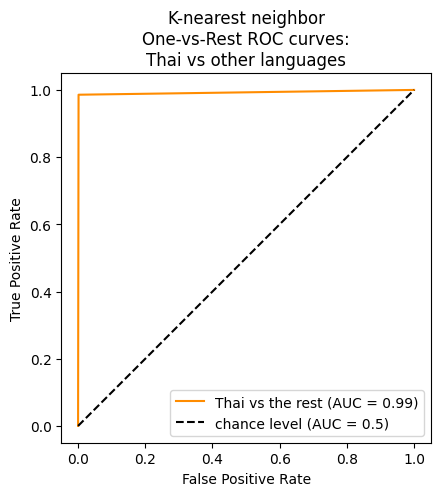

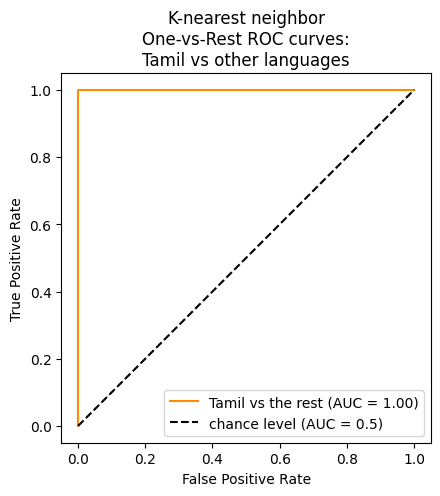

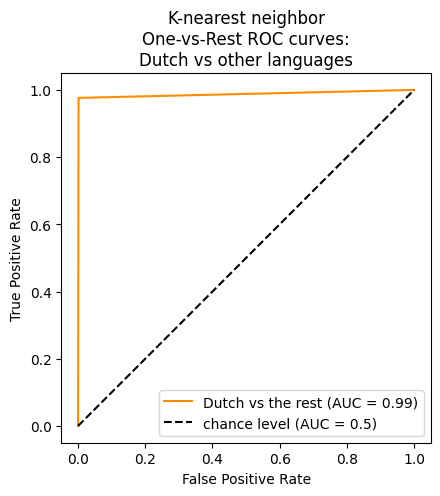

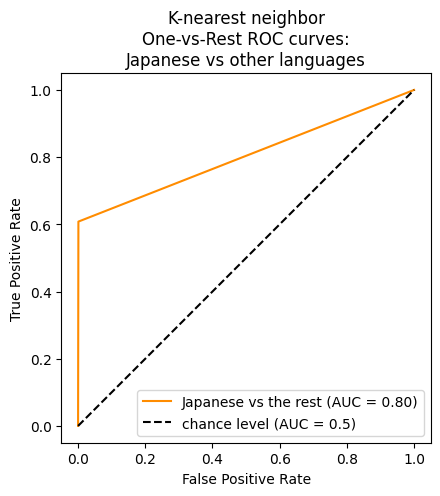

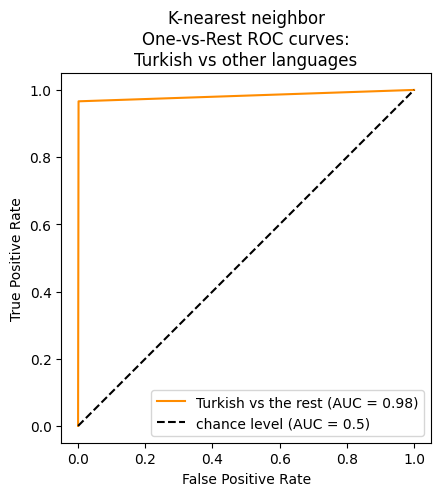

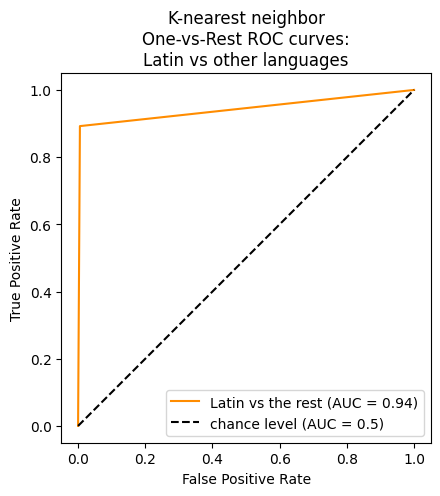

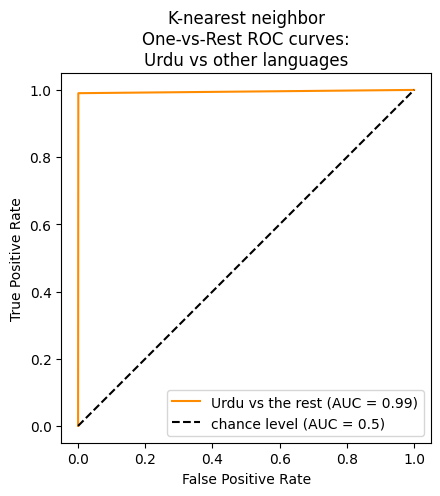

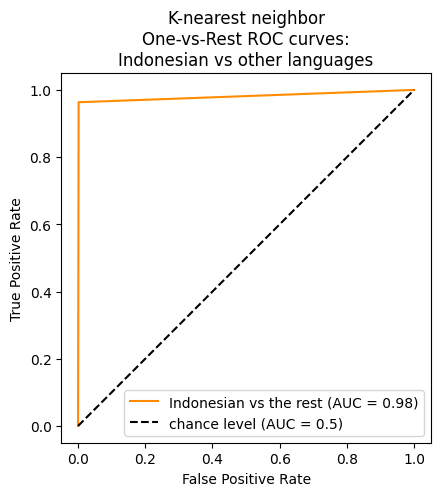

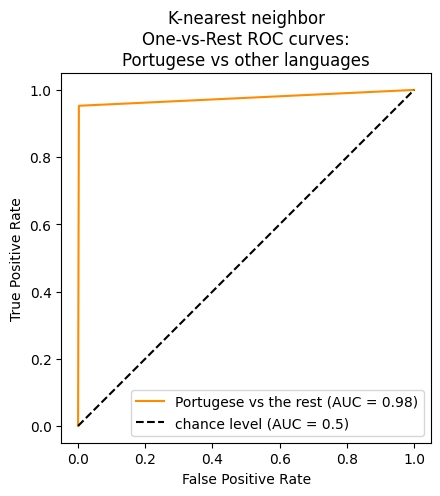

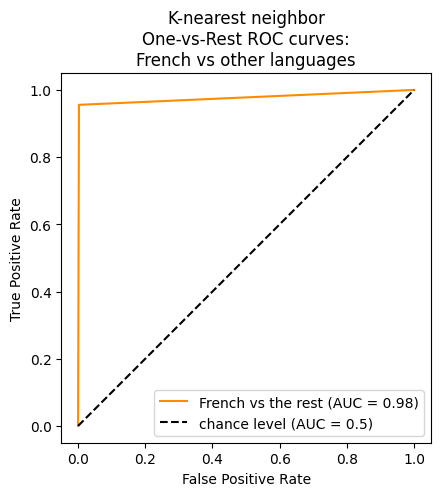

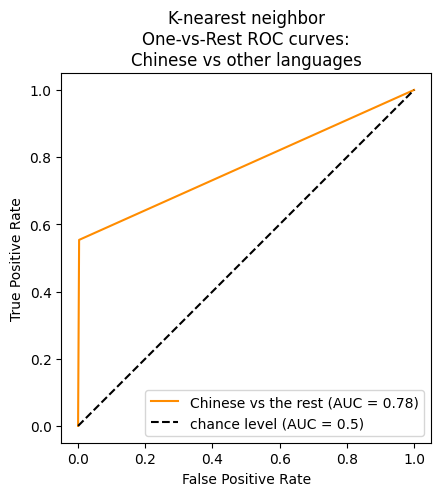

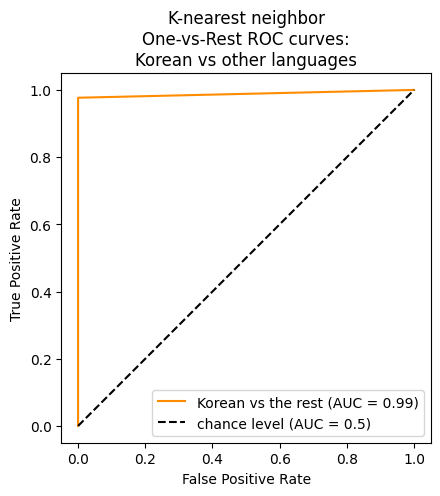

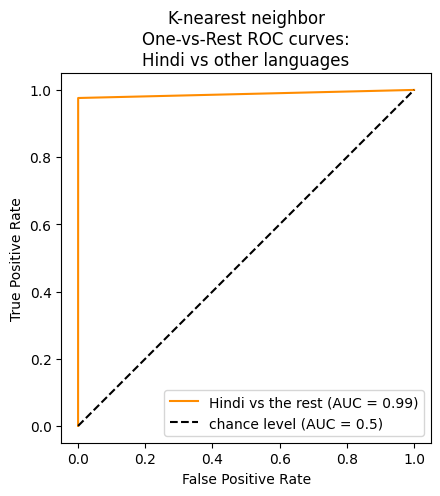

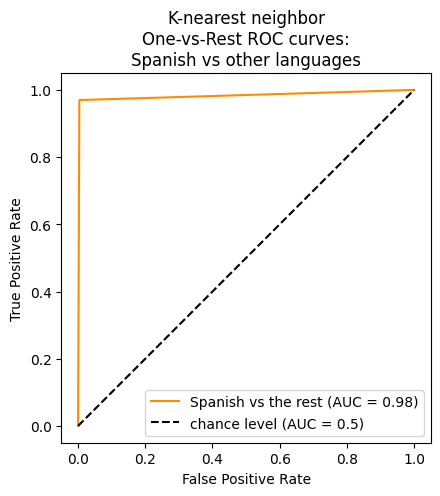

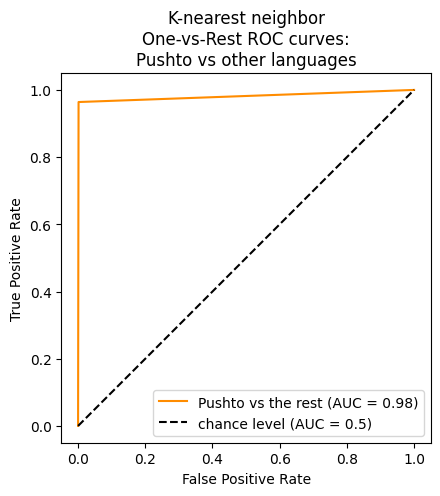

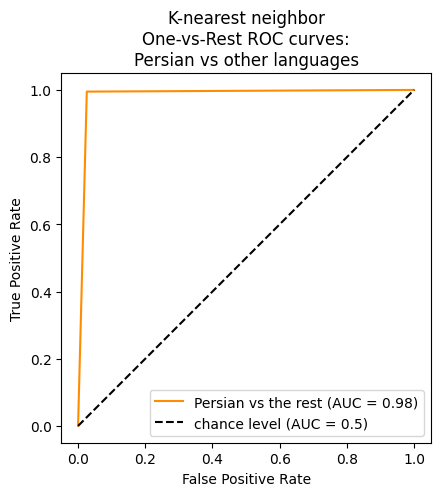

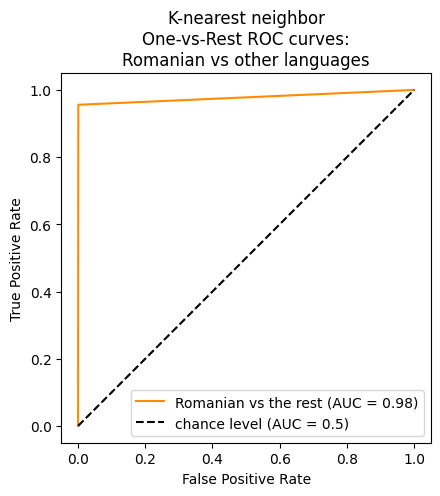

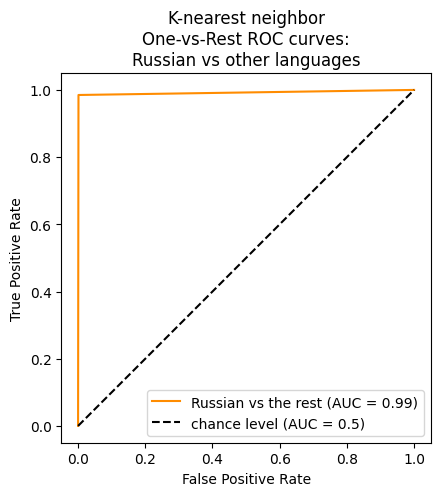

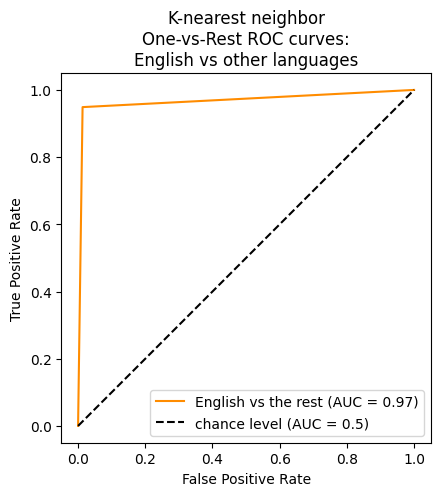

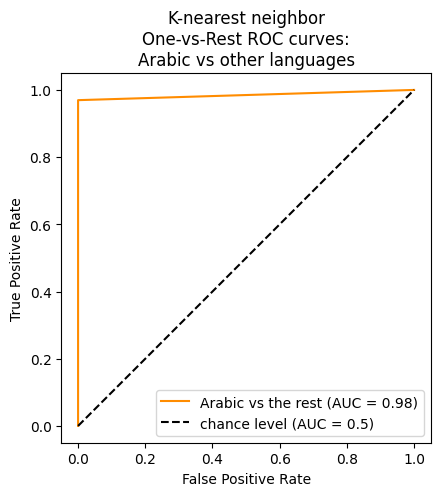

In [17]:
#OvR ROC Curve for K-nearest neighbor

from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import RocCurveDisplay

label_binarizer = LabelBinarizer().fit(y_train)
y_onehot_test = label_binarizer.transform(y_test)

y_score = knn.fit(X_train, y_train).predict_proba(X_test)

for lang in y.unique():
    class_of_interest = lang
    class_id = np.flatnonzero(label_binarizer.classes_ == class_of_interest)[0]
    RocCurveDisplay.from_predictions(
        y_onehot_test[:, class_id],
        y_score[:, class_id],        
        name=f"{class_of_interest} vs the rest",
        color="darkorange",)

    plt.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
    plt.axis("square")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("K-nearest neighbor\nOne-vs-Rest ROC curves:\n" + class_of_interest + " vs other languages")
    plt.legend()
    plt.show()

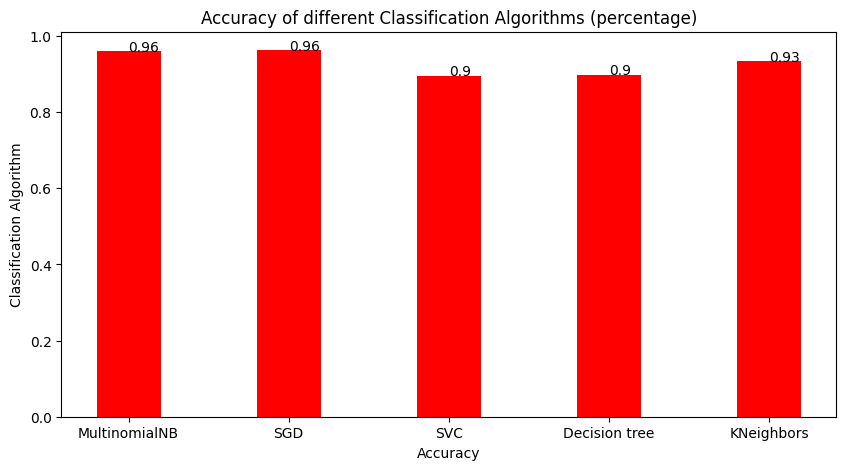

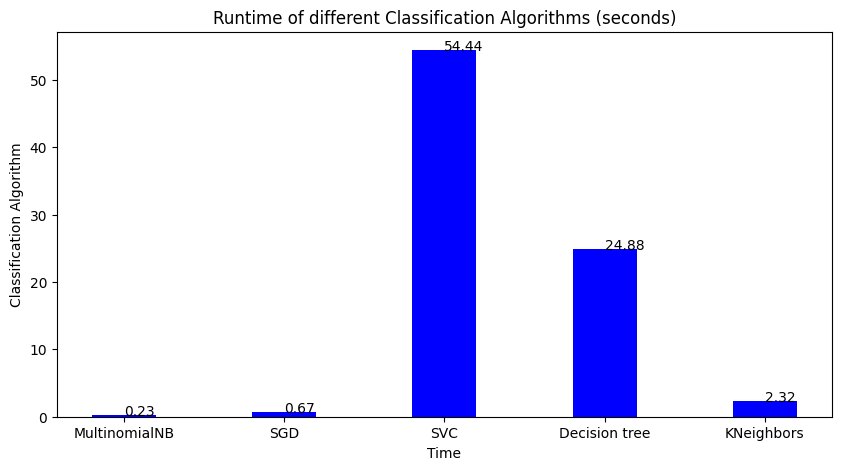

In [19]:
import time
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import SGDClassifier

# Compares the runtime and accuracy of multiple Classification algorithms
classifiers = []
accuracy = []
timings = []

# fast and accurate but a little less than SGD
temp_time = time.time()
clf = MultinomialNB(alpha=0.0001)
clf.fit(X_train, y_train)
classifiers.append("MultinomialNB")
accuracy.append(clf.score(X_test, y_test))
timings.append(time.time() - temp_time)

# most accurate but slower than Multinomial
temp_time = time.time()
clf = SGDClassifier(alpha=0.0001)
clf.fit(X_train, y_train)
clf.score(X_test, y_test)
classifiers.append("SGD")
accuracy.append(clf.score(X_test, y_test))
timings.append(time.time() - temp_time)

# super slow, performs mediocre than most
temp_time = time.time()
clf = SVC()
clf.fit(X_train, y_train)
clf.score(X_test, y_test)
classifiers.append("SVC")
accuracy.append(clf.score(X_test, y_test))
timings.append(time.time() - temp_time)

# about twice as fast as SVC and about as accurate 
temp_time = time.time()
clf = DecisionTreeClassifier()
clf.fit(X_train, y_train)
clf.score(X_test, y_test)
classifiers.append("Decision tree")
accuracy.append(clf.score(X_test, y_test))
timings.append(time.time() - temp_time)

# 
temp_time = time.time()
clf = KNeighborsClassifier(n_neighbors=grid_search.best_params_["n_neighbors"], metric=grid_search.best_params_["metric"])
clf.fit(X_train, y_train)
clf.score(X_test, y_test)
classifiers.append("KNeighbors")
accuracy.append(clf.score(X_test, y_test))
timings.append(time.time() - temp_time)

# plot accuracy
fig = plt.figure(figsize = (10, 5))
plt.bar(classifiers, accuracy, color ='red',width = 0.4)
for i in range(len(classifiers)):
    plt.text(i,accuracy[i],round(accuracy[i], 2))

plt.xlabel("Accuracy")
plt.ylabel("Classification Algorithm")
plt.title("Accuracy of different Classification Algorithms (percentage)")
plt.show()

# plot times
fig = plt.figure(figsize = (10, 5))
plt.bar(classifiers, timings, color ='blue', width = 0.4)
for i in range(len(classifiers)):
    plt.text(i,timings[i],round(timings[i], 2))
    
plt.xlabel("Time")
plt.ylabel("Classification Algorithm")
plt.title("Runtime of different Classification Algorithms (seconds)")
plt.show()